In [1]:
import app
from lib.factor_analysis import plot_correlogram, plot_returns_corr, test_ljung_box, adf_test, find_volitile_month, \
run_regression, regress_all_macro_factors,identify_factor_contribution, restore_rets, stress_calc


# Prepare all the returns and factors

2024-11-07 17:34:17.322 | INFO     | app:preprocess_data:15 - Starting to preprocess data
2024-11-07 17:34:17.323 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TNX
2024-11-07 17:34:17.325 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SQ
2024-11-07 17:34:17.327 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^VIX
2024-11-07 17:34:17.328 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^XAU
2024-11-07 17:34:17.330 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^IRX
2024-11-07 17:34:17.332 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - RIOT
2024-11-07 17:34:17.336 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^TYX
2024-11-07 17:34:17.338 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - NVDA
2024-11-07 17:34:17.340 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - ^FVX
2024-11-07 17:34:17.341 | INFO     | lib.data_preprocessing:read_pickle_prices:20 - SPY
2024-11-07 17:34:17.343


Explained Variance Ratio:
[0.33243404 0.15652964 0.1084148  0.07056208 0.05458006 0.0418448
 0.03310937 0.03016233 0.02811517 0.02402264]
Total Explained Variance Ratio: 0.8798


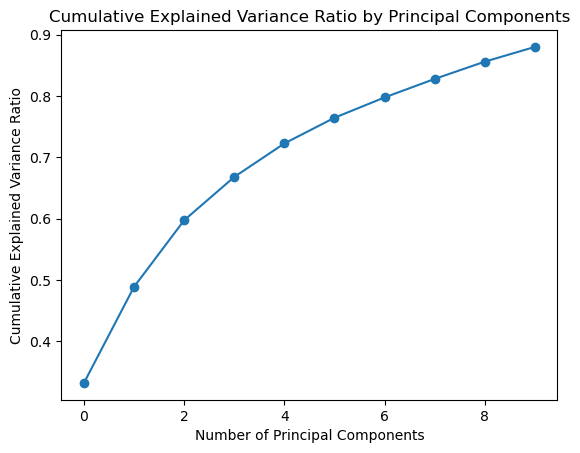

PCA Projection Loss 2.765176628591193


In [2]:
df1 , df_hist_ret, df_vol =app.preprocess_data()
s_crypto_market, s_big_market = app.construct_market_factors(df1)
df_rets0, pc_df0, df_factor_loadings0 = app.construct_pca_factors(df1, s_big_market, s_crypto_market, n=10, standardize_return=True)

<Axes: >

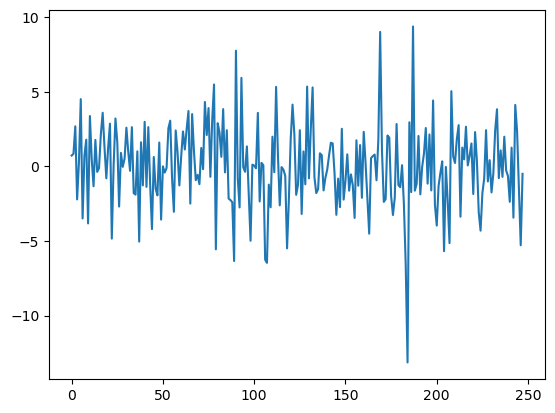

In [3]:
pc_df0['PC1'].plot()

<Axes: >

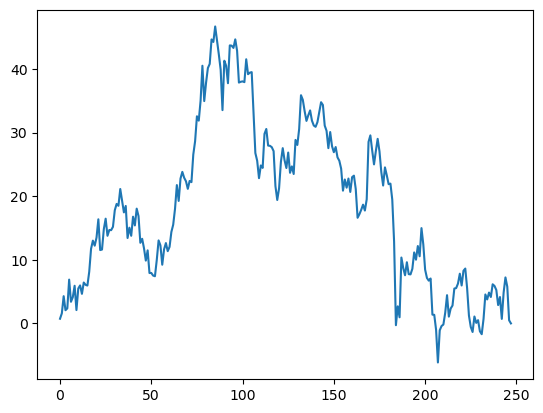

In [4]:
pc_df0['PC1'].cumsum().plot()

<Axes: >

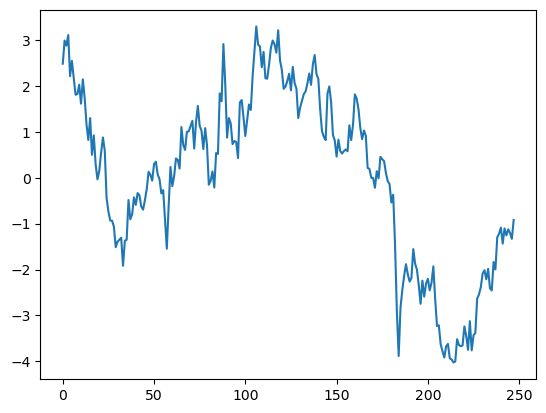

In [5]:
pc_df0['PC2'].plot()

<Axes: >

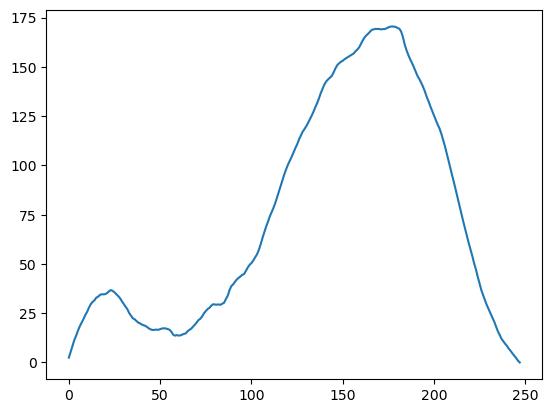

In [6]:
pc_df0['PC2'].cumsum().plot()

<Axes: >

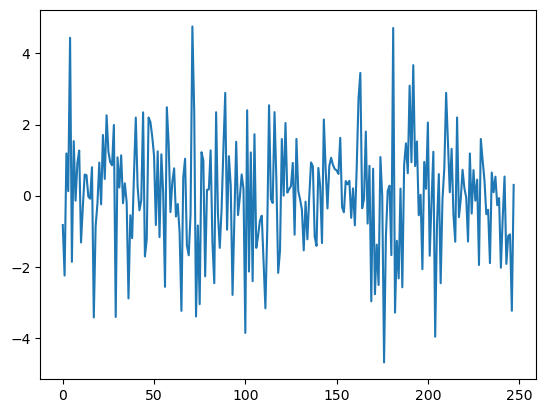

In [7]:
pc_df0['PC3'].plot()

<Axes: >

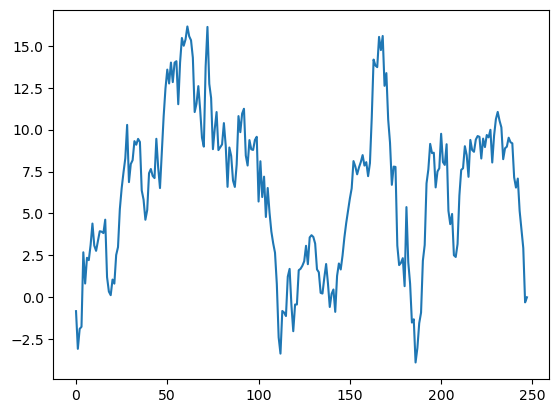

In [8]:
pc_df0['PC3'].cumsum().plot()

# Use only 3 PCA factors to explain price moment of Bitcoin
- 3 factors explained 92.1% of the total variance of Bitcoin returns
- The 1st PCA explained 83.1%
- The 3rd PCA explained 8.9%

#### PC Scores of first 3 PCA components

In [9]:
n = 3
ticker = 'bitcoin_prices' # spy
scores =pc_df0.copy().iloc[:,:n]
scores.index=df_rets0.index
scores

,PC1,PC2,PC3
2023-11-08,0.734047,2.488496,-0.826129
2023-11-09,0.850224,2.993398,-2.247345
2023-11-10,2.696588,2.881693,1.188462
2023-11-13,-2.209209,3.112653,0.126081
2023-11-14,0.296763,2.216288,4.442137
...,...,...,...
2024-10-28,4.131149,-1.256053,-1.919585
2024-10-29,2.386891,-1.123461,-1.131919
2024-10-30,-1.447768,-1.202540,-1.091049
2024-10-31,-5.287887,-1.330935,-3.239268


#### First three factor loadings

In [10]:
import pandas as pd
loadings = df_factor_loadings0[ticker][:n]
loadings=pd.DataFrame(loadings)
loadings.index=scores.columns
loadings

,bitcoin_prices
PC1,0.329621
PC2,-0.012969
PC3,-0.189769


In [11]:
pc_df=pc_df0.copy()
df_rets=df_rets0.copy()

In [12]:
# prepare dataframe
pc_df.index=df_rets0.index
df_rets=df_rets0.join(pc_df)

### Restored Bitcoin Returns from 3 PC scores

<Axes: >

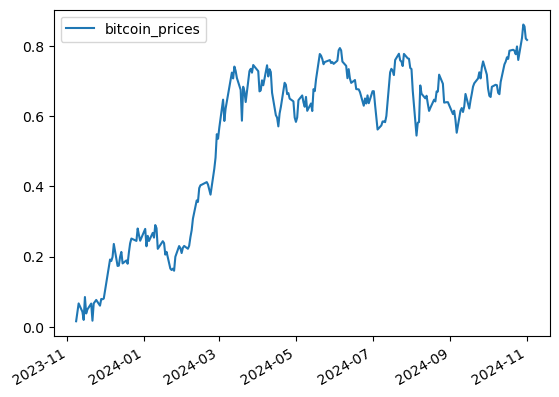

In [13]:
proj= scores.dot(loadings) #
restored = proj*df_rets[ticker].std() + df_rets[ticker].mean()
restored.cumsum().plot()

### Compare with original return

<Axes: >

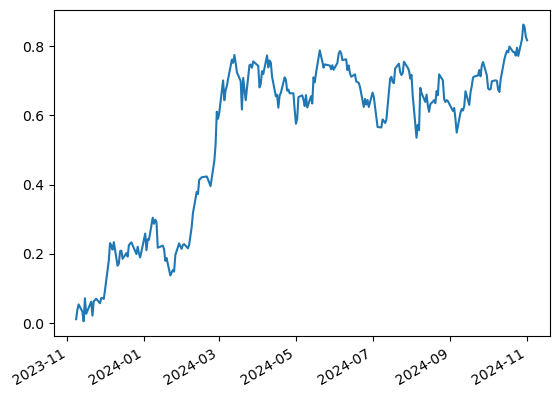

In [14]:
df_rets[ticker].cumsum().plot()

In [15]:
restored[f'original_{ticker}_ret'] = df_rets[ticker]
restored

,bitcoin_prices,original_bitcoin_prices_ret
2023-11-08,0.015828,0.010118
2023-11-09,0.026136,0.027192
2023-11-10,0.024701,0.015661
2023-11-13,-0.023804,-0.021291
2023-11-14,-0.023168,-0.027469
...,...,...
2024-10-28,0.062875,0.048954
2024-10-29,0.038044,0.042033
2024-10-30,-0.005409,-0.006025
2024-10-31,-0.034696,-0.028719


# Factor Contribution for Bitcoin 

In [16]:
m_3=run_regression(df_rets, ["PC1","PC2","PC3"], 'bitcoin_prices',plot_chart=False)
print(f"3 PCA model expalined {m_3.rsquared:.1%} of variance")

3 PCA model expalined 92.1% of variance


In [17]:
m=run_regression(df_rets, ["PC1","PC2"], 'bitcoin_prices',plot_chart=False)
pc3_contribution = m_3.rsquared - m.rsquared
print(f"PC3 expalined {pc3_contribution:.1%} of variance")

PC3 expalined 9.0% of variance


#### Factor Contribution for all cryptos

In [18]:

factor_contributions = identify_factor_contribution(df_rets)        
    
with pd.option_context("display.float_format", "{:.1%}".format):
    display(factor_contributions.T)


,R2_3 PCs,PC1,PC2,PC3
bitcoin_prices,92.1%,83.1%,0.1%,9.0%
usd-coin_prices,1.0%,1.0%,0.0%,0.0%
tether_prices,5.6%,4.4%,0.0%,1.1%
solana_prices,57.7%,54.9%,0.0%,2.8%
chainlink_prices,66.2%,64.6%,0.2%,1.3%
ripple_prices,48.5%,43.5%,0.2%,4.8%
ethereum_prices,75.9%,71.2%,0.0%,4.6%
binancecoin_prices,53.0%,49.4%,0.3%,3.3%
dogecoin_prices,65.7%,59.7%,0.2%,5.9%


# Stress Testing

In [19]:
# this is copied over from GARCH, Volatility Clustering and Correlations.ipynb
high_vol_dates=['2024-03-12', '2024-03-21', '2024-03-22', '2024-03-26',
               '2024-03-27', '2024-03-28', '2024-04-01', '2024-04-02',
               '2024-04-03', '2024-04-04', '2024-04-05', '2024-04-09',
               '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
               '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19',
               '2024-04-23', '2024-08-07', '2024-08-09', '2024-08-12',
               '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16',
               '2024-08-19', '2024-08-20', '2024-08-21', '2024-08-22',
               '2024-08-23', '2024-08-26', '2024-08-27', '2024-08-28',
               '2024-08-29', '2024-08-30', '2024-09-03', '2024-09-04',
               '2024-09-05']

In [20]:
pc_score_high_vol_period = pc_df[pc_df.index.isin(high_vol_dates)].describe()

/var/folders/gz/yxd7yqrx3bx691j1zt5j255w0000gp/T/ipykernel_64701/1196698956.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  pc_score_high_vol_period = pc_df[pc_df.index.isin(high_vol_dates)].describe()


In [21]:
pc_score_high_vol_period

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.953596,-0.227271,0.073071,0.159672,0.108037,0.172315,0.201835,-0.092952,0.045514,0.047740
std,2.311825,2.180667,1.818193,1.414154,0.838809,0.930759,0.844823,0.555419,1.052777,0.530803
min,-6.467572,-3.230449,-3.968258,-4.259454,-1.863687,-2.310578,-1.011349,-2.189177,-1.554315,-0.987117
25%,-1.870541,-2.262169,-0.797918,-0.476468,-0.561276,-0.378207,-0.409436,-0.411208,-0.595598,-0.308582
50%,-0.428528,0.430145,0.192357,0.345023,0.309573,-0.043717,0.179776,-0.025029,-0.097336,-0.042962
75%,0.123824,1.641696,1.234091,1.088835,0.672495,0.809295,0.471700,0.305713,0.437882,0.421507
max,4.429239,3.299986,3.672140,2.846007,1.852531,2.017179,4.007848,1.040170,5.070870,1.293467


In [22]:
means= df_rets0.mean()    
stressed_PC1_score =  - 2*scores['PC1'].std()
stressed_PC2_score =  - 2*scores['PC2'].std()
stressed_PC3_score =  - 2*scores['PC3'].std()

result_pc_shock = {
    'PC1_shock':stress_calc({'PC1': stressed_PC1_score}, df_factor_loadings0,df_rets0),
     'PC2_shock':stress_calc({'PC2': stressed_PC1_score}, df_factor_loadings0,df_rets0),
    'PC3_shock':stress_calc({'PC3': stressed_PC1_score}, df_factor_loadings0,df_rets0),
      'combined': stress_calc({'PC1': stressed_PC1_score, "PC2": stressed_PC2_score, 'PC3': stressed_PC3_score}, df_factor_loadings0,df_rets0),
      }
result_pc_shock=pd.DataFrame(result_pc_shock)

result_pc_shock['hist_high_vol_shock'] = stress_calc({'PC1': pc_score_high_vol_period.loc['min','PC1'], }, df_factor_loadings0,df_rets0)
result_pc_shock

,PC1_shock,PC2_shock,PC3_shock,combined,hist_high_vol_shock
bitcoin_prices,-0.059165,0.005754,0.039257,-0.036943,-0.069604
usd-coin_prices,-0.000186,-0.000049,-0.000027,-0.000235,-0.000217
tether_prices,-0.000354,0.000007,-0.000312,-0.000523,-0.000413
solana_prices,-0.075489,0.006237,0.039405,-0.057460,-0.089269
chainlink_prices,-0.078729,0.007351,0.020441,-0.062791,-0.091990
ripple_prices,-0.050012,0.004474,0.028294,-0.030185,-0.058290
ethereum_prices,-0.067167,-0.000290,0.032760,-0.051152,-0.078724
binancecoin_prices,-0.048164,0.009986,0.027585,-0.030706,-0.056898
dogecoin_prices,-0.086048,0.011415,0.054693,-0.052983,-0.101227
SQ_Close,-0.022198,0.006280,-0.046365,-0.046614,-0.026207
